In [1]:
import pandas as pd
import os
import numpy as np
import glob
import re
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action="ignore")

# for made indexinf in PCA
from sklearn.preprocessing import StandardScaler
from sklearn import decomposition

%matplotlib inline

In [2]:
year = 2014
path = f"C:/Users/Redata/Downloads/read/kemiskinan/hh{year}/"

### Household Asset approach

In [3]:
hr = pd.read_stata(path + "b3a_hr1.dta")[["hr1type",  "hhid14"]] #"hr01", "hr02", "hr05",
hr["ss"] = 0
hr0 = pd.pivot_table(hr, index=['hhid14'],
                    columns=['hr1type'], aggfunc=np.min).replace(0, np.nan)
hr0.columns = [i for i in hr.hr1type.unique()]

###only for 2014 dataset
hr = pd.read_stata(path + "b3a_hr1.dta")[["hr02_" + i.lower() for i in hr.hr1type.unique()] + ["hhid14"]].groupby("hhid14").min()
hr.columns = [i.split("_")[-1].upper() for i in hr.columns]

for i in hr0.columns:
    hr0[i] = hr[i]
###    

hr0 = hr0[hr0.columns[hr0.isnull().sum()/len(hr0) < 0.35]]
hr0.columns = [i+"_hr1type_t" for i in hr0.columns]

hr = pd.read_stata(path + "b3a_hr1.dta")[["hr1type", "hr01",  "hhid14"]] #"hr01", "hr02", "hr05",
hr1 = pd.pivot_table(hr, index=['hhid14'],
                    columns=['hr1type'], aggfunc=np.min).replace(0, np.nan)
hr1.columns = [i+"_hr1type_t" for i in hr.hr1type.unique()]

In [4]:
for i in hr0.columns:
    hr1[i] = (hr1[i] + hr0[i].fillna(0)).apply(lambda x : np.nan if x == 1  else x)

In [5]:
hr = pd.read_stata(path + "b3a_hr2.dta")[["hr2type", "hr16x",  "hhid14"]] #hr16x, hr17x
hr2 = pd.pivot_table(hr, index=['hhid14'],
                    columns=['hr2type'], aggfunc=np.min).replace(0, np.nan)
hr2.columns = [i+"_hr2type_t" for i in hr.hr2type.unique()]

hr = pd.read_stata(path + "b3a_hi.dta")[["hitype", "hi14x",  "hhid14"]]
hr3 = pd.pivot_table(hr, index=['hhid14'],
                    columns=['hitype'], aggfunc=np.min).replace(0, np.nan)
hr3.columns = [i+"_hitype_t" for i in hr.hitype.unique()]

In [6]:
hr = pd.concat([hr1, hr2, hr3], axis=1)
hr.sample(6)

,A_hr1type_t,B_hr1type_t,C_hr1type_t,D1_hr1type_t,D2_hr1type_t,D3_hr1type_t,E_hr1type_t,F_hr1type_t,G_hr1type_t,H_hr1type_t,...,B_hr2type_t,C_hr2type_t,E_hr2type_t,J_hr2type_t,L_hr2type_t,A_hitype_t,B1_hitype_t,B2_hitype_t,C_hitype_t,D1_hitype_t
1241100,100000001.0,1.0,3.0,3.0,3.0,3.0,7000001.0,5000001.0,3.0,3.0,...,3:No purchase,3:No purchase,3:No purchase,3:No purchase,3:No purchase,3:Did not receive,3:Did not receive,3:Did not receive,3:Did not receive,3:Did not receive
0082441,200000001.0,3.0,3.0,1.0,1.0,3.0,20000001.0,10000001.0,3.0,3.0,...,3:No purchase,3:No purchase,3:No purchase,3:No purchase,3:No purchase,3:Did not receive,3:Did not receive,3:Did not receive,3:Did not receive,3:Did not receive
3041711,300000001.0,3.0,3.0,3.0,3.0,3.0,26000001.0,6375001.0,1.0,3.0,...,3:No purchase,3:No purchase,3:No purchase,3:No purchase,3:No purchase,3:Did not receive,3:Did not receive,3:Did not receive,3:Did not receive,3:Did not receive
3071700,NaN,3.0,3.0,1.0,3.0,1.0,7000001.0,3000001.0,3.0,3.0,...,3:No purchase,3:No purchase,3:No purchase,3:No purchase,3:No purchase,3:Did not receive,3:Did not receive,3:Did not receive,3:Did not receive,3:Did not receive
2820500,60000001.0,3.0,3.0,1.0,3.0,3.0,3.0,400001.0,3.0,3.0,...,3:No purchase,3:No purchase,3:No purchase,3:No purchase,3:No purchase,3:Did not receive,3:Did not receive,3:Did not receive,3:Did not receive,3:Did not receive
0032652,3.0,1.0,1.0,3.0,3.0,3.0,15000001.0,5000001.0,3.0,3.0,...,3:No purchase,3:No purchase,3:No purchase,3:No purchase,1:Given,3:Did not receive,3:Did not receive,3:Did not receive,3:Did not receive,3:Did not receive


In [7]:
for i in hr.columns:
    hr[i] = hr[i].astype("str").str.extract(r'(\d+)')[0].astype("float").apply(lambda x: np.nan if x == 999999996 else x)
    if i not in ["A_hr1type_t", "E_hr1type_t", "F_hr1type_t"]:
        hr[i] = hr[i].fillna(hr[i].median())
        hr[i] = hr[i].apply(lambda x: 0 if x != 1 else x)
hr.sample(10)

,A_hr1type_t,B_hr1type_t,C_hr1type_t,D1_hr1type_t,D2_hr1type_t,D3_hr1type_t,E_hr1type_t,F_hr1type_t,G_hr1type_t,H_hr1type_t,...,B_hr2type_t,C_hr2type_t,E_hr2type_t,J_hr2type_t,L_hr2type_t,A_hitype_t,B1_hitype_t,B2_hitype_t,C_hitype_t,D1_hitype_t
2870300,60000001.0,0.0,0.0,1.0,0.0,0.0,11000001.0,7250001.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
0741421,NaN,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1851400,50000001.0,0.0,0.0,1.0,0.0,0.0,100001.0,200001.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1170500,300000001.0,1.0,0.0,0.0,0.0,0.0,253000001.0,26000001.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1432751,NaN,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0191200,3.0,0.0,0.0,0.0,0.0,0.0,8000001.0,1000001.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3040200,NaN,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1041900,80000001.0,0.0,0.0,0.0,0.0,0.0,10300001.0,3000001.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2600753,3.0,0.0,0.0,0.0,0.0,0.0,4000001.0,2000001.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1782400,NaN,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Little bit doing PCA in HR section in Making Index

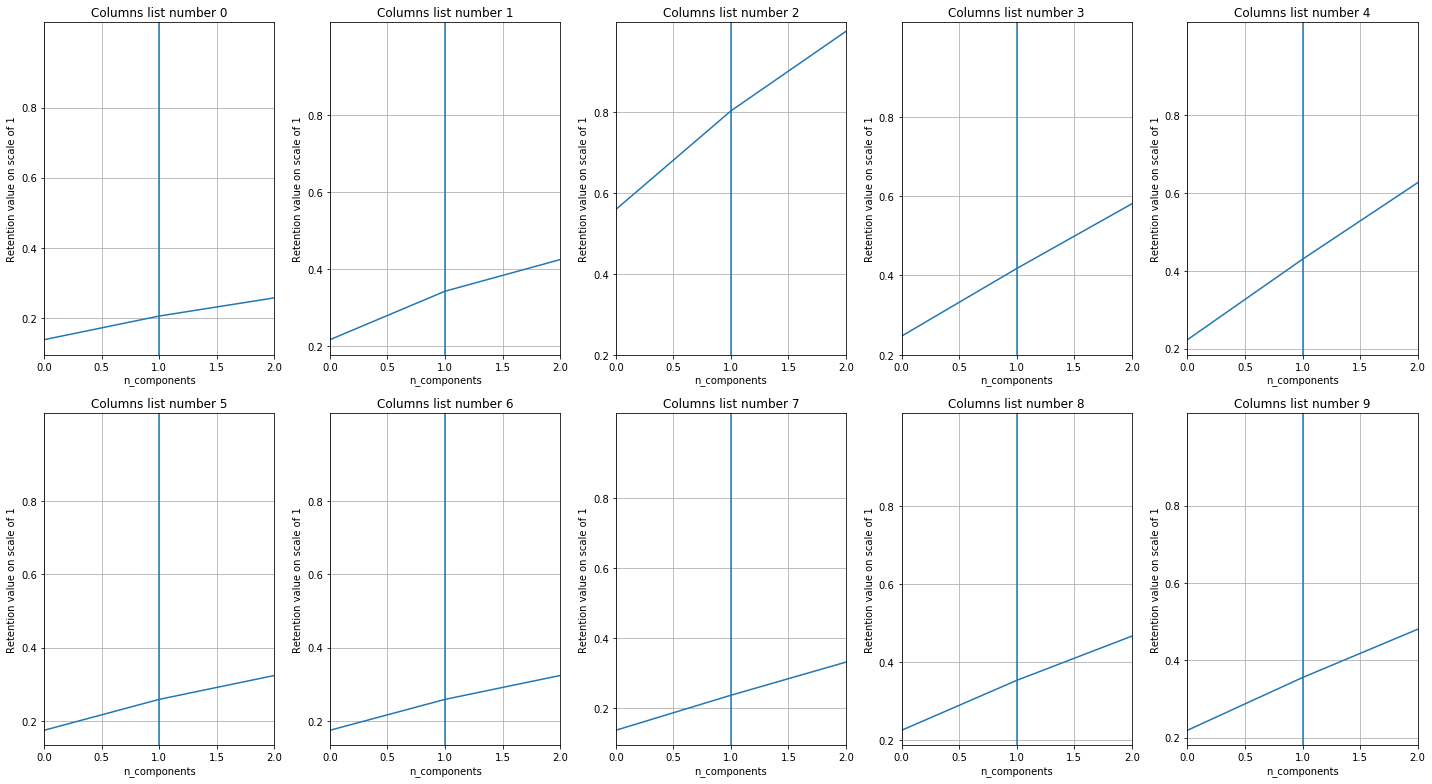

In [8]:
numeric_col = ["A_hr1type_t", "E_hr1type_t", "F_hr1type_t"]

#we have several combination of columns in order to get highest variance in n_component equal to 1.
my_col_list = [hr.columns, hr1.columns, numeric_col, hr2.columns, hr3.columns, list(hr1.columns)+list(hr2.columns), 
              list(hr1.columns)+list(hr2.columns), list(hr2.columns) + list(hr3.columns), 
               numeric_col+ list(hr2.columns), numeric_col+ list(hr3.columns)]

plt.figure(figsize=(20, 11))
for i in range(len(my_col_list)):
    df = hr[my_col_list[i]]
    df = df.fillna(df.median()) #hr dataset
    standarized_data = StandardScaler().fit_transform(df)
    pca = decomposition.PCA(n_components=1)
    pca_data = pca.fit_transform(standarized_data)
    pca.n_components = df.shape[1]
    pca_data = pca.fit_transform(standarized_data)
    retention_value = pca.explained_variance_ / np.sum(pca.explained_variance_);
    cumulative_retention = np.cumsum(retention_value)
    plt.subplot(2, 5, i+1)
    plt.plot(cumulative_retention)
    plt.tight_layout()
    plt.grid()
    plt.axvline(1)
    plt.xlim(0,2)
    plt.yticks([0.2, 0.4, 0.6, 0.8])
    plt.title(f"Columns list number {i}")
    plt.xlabel('n_components')
    plt.ylabel('Retention value on scale of 1');